In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
from scipy.stats import norm
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import torch.nn.functional as F
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [86]:
epochs = 200
rTrain = 0.7;
rTest = 0.2;
rValidation = 0.1
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

# Definition of the structure

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=50, kernel_size=2, stride=1, padding=1)# 100
        self.batch1 = nn.BatchNorm1d(num_features=50)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, return_indices=True)
        
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=20, kernel_size=2, stride=1, padding=1)# 40
        self.batch2 = nn.BatchNorm1d(num_features=20)
        self.act2 = nn.ReLU()
#         self.pool2 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=50, kernel_size=2, stride=1, padding=1)# 100
        self.batch3 = nn.BatchNorm1d(num_features=50)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv4 = nn.Conv1d(in_channels=50, out_channels=1, kernel_size=2, padding=1)
        self.final = nn.Tanh()

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x);
        x = self.batch1(x);
        x = self.act1(x);
        x, indices = self.pool1(x);
#         print(x.shape)
#         x = self.pool1(self.act1(self.batch1(self.conv1(x))))
        encoded = self.act2(self.conv2(x))
#         print(encoded.shape)
        
        x = self.conv3(encoded)
        x = self.batch3(x);
        x = self.act3(x);
#         print(x.shape)
        x = self.pool3(x, indices);

#         x = self.final(self.conv4(x))
        x = self.conv4(x)

        return encoded, x

## Below is the model for Supervised Learning. We want to investigate its performance for glitch exclusion

In [44]:
class WaveletCNNSL(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128,
        lx: int=200
    ):
        
        super(WaveletCNNSL, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.body_norm = nn.GroupNorm(4 ,n_chann)
        self.end_norm = nn.BatchNorm1d(1)
        
        self.WaveNet_layers = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers.append(conv_layer)
        
        
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth+1)
        self.L1 = nn.Linear(200-2**c_depth+1, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        self.L3_norm = nn.BatchNorm1d(l2)
        self.L3 = nn.Linear(l2, 1)


        nn.init.kaiming_normal_(self.Conv_In.weight)
        nn.init.kaiming_normal_(self.Conv_Out.weight)
        nn.init.constant_(self.Conv_In.bias, 0.001)
        nn.init.constant_(self.Conv_Out.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
    def forward(self, x):

        x = self.cap_norm(x)
        x = self.Conv_In(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers:
            x = self.body_norm(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out(x)
        x = F.relu(x)
        x = self.end_norm(x)
        
        x = torch.flatten(x, 1)
        
        
        x = F.relu(self.L1(x))
        x = self.L2_norm(x)
        x = F.relu(self.L2(x))
        x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        x = self.L3(x)
        
        return x

## Below is the model for AE. We don't know whether this is suitable for AE case. 

### One channel for DNN

In [4]:
class WaveletCNNAE(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128
        # lx: int=200
    ):
        
        super(WaveletCNNAE, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=1, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(1)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
        
        
        self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        # self.L3_norm = nn.BatchNorm1d(l2)
        # self.L3 = nn.Linear(l2, 1)
        self.L4_norm = nn.BatchNorm1d(l2)
        self.L4 = nn.Linear(l2, l1)
        self.L5_norm = nn.BatchNorm1d(l1)
        self.L5 = nn.Linear(l1, 200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
        nn.init.kaiming_uniform_(self.L4.weight)
        nn.init.kaiming_uniform_(self.L5.weight)
        nn.init.constant_(self.L4.bias, 0.001)
        nn.init.constant_(self.L5.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        # print(x.shape)
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        x = torch.flatten(x, 1)
        
        # print(x.shape)
        
        x = F.relu(self.L1(x))
        # print(x.shape)
        x = self.L2_norm(x)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = self.L2(x)
        x = F.relu(x)
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        # print(x.shape)
        x = self.L4_norm(x)
        # print(x.shape)
        x = F.relu(self.L4(x))
        # print(x.shape)
        x = self.L5_norm(x)
        # print(x.shape)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = F.relu(self.L5(x))
        # print(x.shape)
        # print('DNN done')
        
        x = self.Padding_layer(x)
        
        x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_decode:
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

### Multi-channel for DNN

In [56]:
class WaveletCNNAEMC(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128
        # lx: int=200
    ):
        
        super(WaveletCNNAEMC, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(n_chann)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
        
        
        self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        # self.L3_norm = nn.BatchNorm1d(l2)
        # self.L3 = nn.Linear(l2, 1)
        self.L4_norm = nn.BatchNorm1d(l2)
        self.L4 = nn.Linear(l2, l1)
        self.L5_norm = nn.BatchNorm1d(l1)
        self.L5 = nn.Linear(l1, 200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
        nn.init.kaiming_uniform_(self.L4.weight)
        nn.init.kaiming_uniform_(self.L5.weight)
        nn.init.constant_(self.L4.bias, 0.001)
        nn.init.constant_(self.L5.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        # print(x.shape)
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        # x = torch.flatten(x, 1)
        
        # print(x.shape)
        
        x = F.relu(self.L1(x))
        # print(x.shape)
        x = self.L2_norm(x.permute(0,2,1)).permute(0,2,1)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = self.L2(x)
        x = F.relu(x)
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        # print(x.shape)
        x = self.L4_norm(x.permute(0,2,1)).permute(0,2,1)
        # print(x.shape)
        x = F.relu(self.L4(x))
        # print(x.shape)
        x = self.L5_norm(x.permute(0,2,1)).permute(0,2,1)
        # print(x.shape)
        # x = F.relu(self.L2(x))
        # x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        # x = self.L3(x)
        x = F.relu(self.L5(x))
        # print(x.shape)
        # print('DNN done')
        
        x = self.Padding_layer(x)
        
        # x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_decode:
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

### If there's no DNN

In [116]:
class WaveletCNNAEND(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128
        # lx: int=200
    ):
        
        super(WaveletCNNAEND, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(n_chann)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
        
        
        self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        # self.L1_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        # self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        # self.L2_norm = nn.BatchNorm1d(l1)
        # self.L2 = nn.Linear(l1, l2)
        # # self.L3_norm = nn.BatchNorm1d(l2)
        # # self.L3 = nn.Linear(l2, 1)
        # self.L4_norm = nn.BatchNorm1d(l2)
        # self.L4 = nn.Linear(l2, l1)
        # self.L5_norm = nn.BatchNorm1d(l1)
        # self.L5 = nn.Linear(l1, 200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        # nn.init.kaiming_uniform_(self.L1.weight)
        # nn.init.kaiming_uniform_(self.L2.weight)
        # nn.init.constant_(self.L1.bias, 0.001)
        # nn.init.constant_(self.L2.bias, 0.001)
        
        # nn.init.kaiming_uniform_(self.L4.weight)
        # nn.init.kaiming_uniform_(self.L5.weight)
        # nn.init.constant_(self.L4.bias, 0.001)
        # nn.init.constant_(self.L5.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        # print(x.shape)
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        # x = torch.flatten(x, 1)
        
        # print(x.shape)
        
        # x = F.relu(self.L1(x))
        # # print(x.shape)
        # x = self.L2_norm(x.permute(0,2,1)).permute(0,2,1)
        # # x = F.relu(self.L2(x))
        # # x = self.L3_norm(x)
        # # x = F.softmax(self.L3(x), dim = 1)
        # # x = self.L3(x)
        # x = self.L2(x)
        # x = F.relu(x)
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        # print(x.shape)
        # x = self.L4_norm(x.permute(0,2,1)).permute(0,2,1)
        # # print(x.shape)
        # x = F.relu(self.L4(x))
        # # print(x.shape)
        # x = self.L5_norm(x.permute(0,2,1)).permute(0,2,1)
        # # print(x.shape)
        # # x = F.relu(self.L2(x))
        # # x = self.L3_norm(x)
        # # x = F.softmax(self.L3(x), dim = 1)
        # # x = self.L3(x)
        # x = F.relu(self.L5(x))
        # print(x.shape)
        # print('DNN done')
        
        x = self.Padding_layer(x)
        
        # x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_decode:
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

# Loading the dataset

## Chia-Jui dataset

### Reading the data from file

In [177]:
## If one is using Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L[:1000000], realbkg_H[:1000000]), axis = 1).reshape(-1,200)

del realbkg_L, realbkg_H

realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

### Making the glitch set (one detector + one noise)

In [178]:
noise_first50k = realbkg.reshape(-1,2,200)[:30000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)
realbkg = realbkg[60000:]

del realglitch_L, realglitch_H, glitch_H_noise_L, glitch_L_noise_H

### Normalize the dataset

In [67]:
realbkg = (realbkg - np.transpose([np.mean(realbkg, axis=1)]))/np.transpose([np.std(realbkg, axis=1)]);
realbbh = (realbbh - np.transpose([np.mean(realbbh, axis=1)]))/np.transpose([np.std(realbbh, axis=1)]);
realsg  = (realsg  - np.transpose([np.mean(realsg , axis=1)]))/np.transpose([np.std(realsg, axis=1)]);
realglitch = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

In [179]:
realbkg = realbkg / np.linalg.norm(realbkg, axis = 1).reshape(-1,1)
realbbh = realbbh / np.linalg.norm(realbbh, axis = 1).reshape(-1,1)
realsg  = realsg / np.linalg.norm(realsg, axis = 1).reshape(-1,1)
realglitch = realglitch / np.linalg.norm(realglitch, axis = 1).reshape(-1,1)

### Reserve a certain propotion of set for further study

In [180]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2:]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2:]
realsg_reserved = realsg[-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2:]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2:]

realbkg = realbkg[:-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
realglitch = realglitch[:-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2]

### Final Package

In [181]:
realbkg = realbkg.reshape(-1,2,200)
realbbh = realbbh.reshape(-1,2,200)
realsg = realsg.reshape(-1,2,200)
realglitch = realglitch.reshape(-1,2,200)

In [142]:
realbkg.shape

(776000, 2, 200)

In [182]:
realbkg_reserved = realbkg_reserved.reshape(-1,2,200)
realbbh_reserved = realbbh_reserved.reshape(-1,2,200)
realsg_reserved = realsg_reserved.reshape(-1,2,200)
realglitch_reserved = realglitch_reserved.reshape(-1,2,200)

## GWAK dataset

### Reading the data from file

In [162]:
## If one is using GWAK set

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'].reshape(-1,200) / renorm_factor_0;
realbbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy').reshape(-1,200) / renorm_factor_0;

realsg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy').reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

### Making the glitch set (one detector + one noise)

In [163]:
noise_first50k = realbkg.reshape(-1,2,200)[:30000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)
realbkg = realbkg[60000:]

del realglitch_L, realglitch_H, glitch_H_noise_L, glitch_L_noise_H

### Normalize the dataset

In [161]:
realbkg = (realbkg - np.transpose([np.mean(realbkg, axis=1)]))/np.transpose([np.std(realbkg, axis=1)]);
realbbh = (realbbh - np.transpose([np.mean(realbbh, axis=1)]))/np.transpose([np.std(realbbh, axis=1)]);
realsg  = (realsg  - np.transpose([np.mean(realsg , axis=1)]))/np.transpose([np.std(realsg, axis=1)]);
realglitch = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

In [164]:
realbkg = realbkg / np.linalg.norm(realbkg, axis = 1).reshape(-1,1)
realbbh = realbbh / np.linalg.norm(realbbh, axis = 1).reshape(-1,1)
realsg  = realsg / np.linalg.norm(realsg, axis = 1).reshape(-1,1)
realglitch = realglitch / np.linalg.norm(realglitch, axis = 1).reshape(-1,1)

### Reserve a certain propotion of set for further study

In [165]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2:]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2:]
realsg_reserved = realsg[-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2:]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2:]

realbkg = realbkg[:-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
realglitch = realglitch[:-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2]

### Final Package

In [166]:
realbkg = realbkg.reshape(-1,2,200)
realbbh = realbbh.reshape(-1,2,200)
realsg = realsg.reshape(-1,2,200)
realglitch = realglitch.reshape(-1,2,200)

In [167]:
realbkg.shape

(56000, 2, 200)

In [168]:
realbkg_reserved = realbkg_reserved.reshape(-1,2,200)
realbbh_reserved = realbbh_reserved.reshape(-1,2,200)
realsg_reserved = realsg_reserved.reshape(-1,2,200)
realglitch_reserved = realglitch_reserved.reshape(-1,2,200)

# Training the model

## For supervised learning case

### Trained with noise

In [38]:
version = 'v1'
dInput = 200

In [45]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

Epoch: 0094, Training loss=0.000597, Validation loss=0.015089, valid accuracy=30.028818
Time for this epoch: 128.94940900802612


In [41]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realglitch[:n_GLITCH_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realbkg[:n_BKG_train]), axis = 0)
target_train = np.concatenate((np.ones(n_GLITCH_train + n_BBH_train + n_SG_train), np.zeros(n_BKG_train)))

X_validation = np.concatenate((realglitch[-n_GLITCH_validation:], 
                          realbbh[-n_BBH_validation:], 
                          realsg[-n_SG_validation:], 
                          realbkg[-n_BKG_validation:]), axis = 0)
target_validation = np.concatenate((np.ones(n_GLITCH_validation + n_BBH_validation + n_SG_validation), np.zeros(n_BKG_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [42]:
X_train.shape

(744233, 2, 200)

In [45]:
classifier = WaveletCNNSL(num_ifos=2, c_depth=5, n_chann=8, l1=64, l2=16).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([n_GLITCH_train/(n_BKG_train + n_BBH_train + n_SG_train)])).cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_SL_noisetrained"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

13170
Epoch: 0001, Training loss=0.003075, Validation loss=0.015904, valid accuracy=30.028818
Time for this epoch: 129.90688848495483
Epoch: 0002, Training loss=0.046359, Validation loss=0.015486, valid accuracy=30.028818
Time for this epoch: 129.0955696105957
Epoch: 0003, Training loss=0.003210, Validation loss=0.015535, valid accuracy=30.029169
Time for this epoch: 131.192809343338
Epoch: 0004, Training loss=0.001686, Validation loss=0.015377, valid accuracy=30.029169
Time for this epoch: 129.25594282150269
Epoch: 0005, Training loss=0.001491, Validation loss=0.015311, valid accuracy=30.028818
Time for this epoch: 128.64245557785034
Epoch: 0006, Training loss=0.000947, Validation loss=0.015329, valid accuracy=30.029169
Time for this epoch: 128.9802668094635
Epoch: 0007, Training loss=0.051127, Validation loss=0.015243, valid accuracy=30.029169
Time for this epoch: 128.92957282066345
Epoch: 0008, Training loss=0.002679, Validation loss=0.015149, valid accuracy=30.028818
Time for this 

### Trained with glitch

In [ ]:
version = 'v1'
dInput = 200

In [ ]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

In [ ]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realbkg[:n_BKG_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realglitch[:n_GLITCH_train]), axis = 0)
target_train = np.concatenate((np.ones(n_BKG_train + n_BBH_train + n_SG_train), np.zeros(n_GLITCH_train)))

X_validation = np.concatenate((realbkg[:n_BKG_validation], 
                          realbbh[:n_BBH_validation], 
                          realsg[:n_SG_validation], 
                          realglitch[:n_GLITCH_validation]), axis = 0)
target_validation = np.concatenate((np.ones(n_BKG_validation + n_BBH_validation + n_SG_validation), np.zeros(n_GLITCH_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
X_train.shape

(744233, 2, 200)

In [ ]:
classifier = WaveletCNNSL(num_ifos=2, c_depth=5, n_chann=8, l1=64, l2=16).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([n_GLITCH_train/(n_BKG_train + n_BBH_train + n_SG_train)])).cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_SL"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

NameError: name 'WaveletCNNSL' is not defined

### Trained with noise

## For unsupervised learning case

### Trained with glitch

In [169]:
version = 'v12'
dInput = 200

In [170]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

In [171]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)

In [ ]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realbkg[:n_BKG_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realglitch[:n_GLITCH_train]), axis = 0)
target_train = np.concatenate((np.ones(n_BKG_train + n_BBH_train + n_SG_train), np.zeros(n_GLITCH_train)))

X_validation = np.concatenate((realbkg[-n_BKG_validation:], 
                          realbbh[-n_BBH_validation:], 
                          realsg[-n_SG_validation:], 
                          realglitch[-n_GLITCH_validation:]), axis = 0)
target_validation = np.concatenate((np.ones(n_BKG_validation + n_BBH_validation + n_SG_validation), np.zeros(n_GLITCH_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

MemoryError: Unable to allocate 2.22 GiB for an array with shape (744233, 2, 200) and data type float64

In [172]:
X_train = realglitch[:n_GLITCH_train]
X_validation = realglitch[-n_GLITCH_validation:]

train_dataset = TensorDataset(torch.FloatTensor(X_train))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [173]:
X_train.shape

(43200, 2, 200)

524
Epoch: 0001, Training loss=0.008375, Validation loss=0.008354, valid accuracy=0.000000
Time for this epoch: 11.290385484695435
Epoch: 0002, Training loss=0.005079, Validation loss=0.005032, valid accuracy=0.000000
Time for this epoch: 10.738962411880493
Epoch: 0003, Training loss=0.005007, Validation loss=0.005005, valid accuracy=0.000000
Time for this epoch: 10.74092960357666
Epoch: 0004, Training loss=0.005015, Validation loss=0.005008, valid accuracy=0.000000
Time for this epoch: 10.758487939834595
Epoch: 0005, Training loss=0.004991, Validation loss=0.004997, valid accuracy=0.000000
Time for this epoch: 10.689968347549438
Epoch: 0006, Training loss=0.004984, Validation loss=0.004993, valid accuracy=0.000000
Time for this epoch: 10.79765272140503
Epoch: 0007, Training loss=0.004984, Validation loss=0.004987, valid accuracy=0.000000
Time for this epoch: 10.992913961410522
Epoch: 0008, Training loss=0.004977, Validation loss=0.004979, valid accuracy=0.000000
Time for this epoch: 1

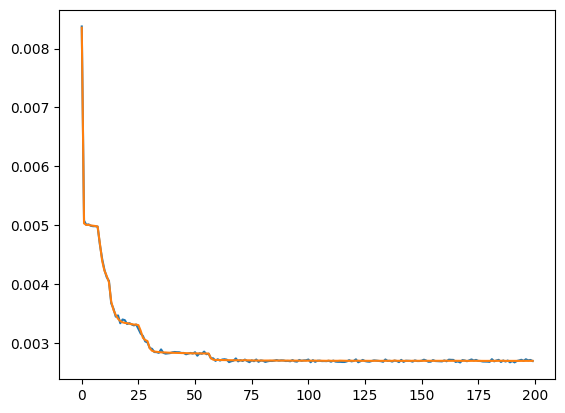

In [174]:
classifier = WaveletCNNAEND(num_ifos=2, c_depth=6, n_chann=4, l1=32, l2=8).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_glitchtrained_AE"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

10398
Epoch: 0001, Training loss=0.007640, Validation loss=0.007472, valid accuracy=0.000000
Time for this epoch: 12.621614933013916
Epoch: 0002, Training loss=0.005013, Validation loss=0.005031, valid accuracy=0.000000
Time for this epoch: 12.428460597991943
Epoch: 0003, Training loss=0.005017, Validation loss=0.005013, valid accuracy=0.000000
Time for this epoch: 12.737011432647705
Epoch: 0004, Training loss=0.005002, Validation loss=0.005007, valid accuracy=0.000000
Time for this epoch: 12.525739908218384
Epoch: 0005, Training loss=0.005000, Validation loss=0.005003, valid accuracy=0.000000
Time for this epoch: 12.60418438911438
Epoch: 0006, Training loss=0.005001, Validation loss=0.005002, valid accuracy=0.000000
Time for this epoch: 12.522086143493652
Epoch: 0007, Training loss=0.005001, Validation loss=0.005001, valid accuracy=0.000000
Time for this epoch: 12.676679849624634
Epoch: 0008, Training loss=0.005002, Validation loss=0.005001, valid accuracy=0.000000
Time for this epoch

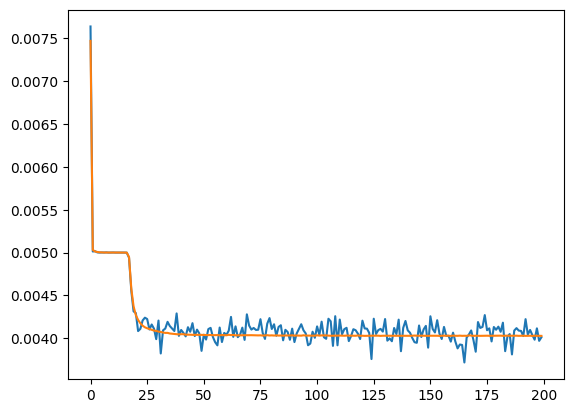

In [149]:
version = 'v10'

classifier = WaveletCNNAE(num_ifos=2, c_depth=6, n_chann=4, l1=32, l2=8).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_glitchtrained_AE"+version+"_32_8.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

10431
Epoch: 0001, Training loss=0.005093, Validation loss=0.005083, valid accuracy=0.000000
Time for this epoch: 13.10512900352478
Epoch: 0002, Training loss=0.005004, Validation loss=0.005007, valid accuracy=0.000000
Time for this epoch: 13.178333282470703
Epoch: 0003, Training loss=0.005001, Validation loss=0.005002, valid accuracy=0.000000
Time for this epoch: 13.415843486785889
Epoch: 0004, Training loss=0.005003, Validation loss=0.005001, valid accuracy=0.000000
Time for this epoch: 13.134289503097534
Epoch: 0005, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 13.22403597831726
Epoch: 0006, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 13.184117794036865
Epoch: 0007, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch: 13.183037281036377
Epoch: 0008, Training loss=0.005000, Validation loss=0.005000, valid accuracy=0.000000
Time for this epoch:

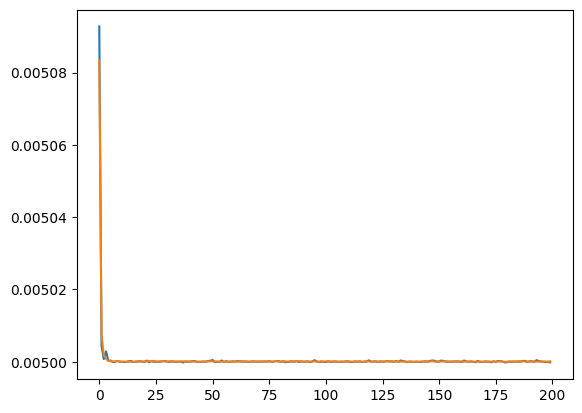

In [150]:
version = 'v11'

classifier = WaveletCNNAEMC(num_ifos=2, c_depth=6, n_chann=4, l1=32, l2=8).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_glitchtrained_AE"+version+"_32_8.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

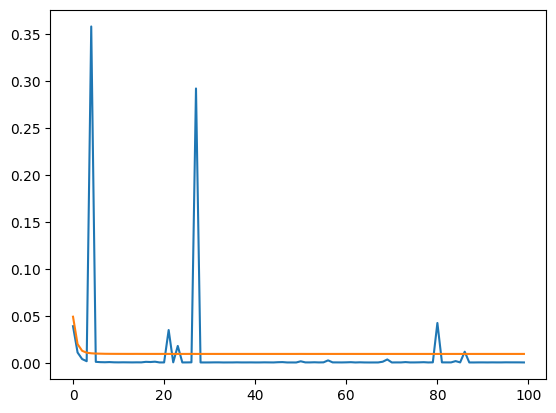

In [79]:
plt.plot(loss_train)
plt.plot(loss_validation)

### Trained with noise

In [9]:
version = 'v1'
dInput = 200

In [10]:
n_BKG = len(realbkg)
n_BBH = len(realbbh)
n_SG = len(realsg)
n_GLITCH = len(realglitch)

In [12]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)

In [37]:
# Beacuse there's already 20% of dataset reserved here, there's no meaning setting the testset. We only do
# training and validation here. 

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_BBH_train = int(n_BBH * rTrain)
n_SG_train = int(n_SG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_BBH_validation = int(n_BBH * rValidation)
n_SG_validation = int(n_SG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)


X_train = np.concatenate((realbkg[:n_BKG_train], 
                          realbbh[:n_BBH_train], 
                          realsg[:n_SG_train], 
                          realglitch[:n_GLITCH_train]), axis = 0)
target_train = np.concatenate((np.ones(n_BKG_train + n_BBH_train + n_SG_train), np.zeros(n_GLITCH_train)))

X_validation = np.concatenate((realbkg[-n_BKG_validation:], 
                          realbbh[-n_BBH_validation:], 
                          realsg[-n_SG_validation:], 
                          realglitch[-n_GLITCH_validation:]), axis = 0)
target_validation = np.concatenate((np.ones(n_BKG_validation + n_BBH_validation + n_SG_validation), np.zeros(n_GLITCH_validation)))


train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(target_validation.reshape((len(target_validation), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

MemoryError: Unable to allocate 2.22 GiB for an array with shape (744233, 2, 200) and data type float64

In [31]:
X_train = realbkg[:n_BKG_train]
X_validation = realbkg[-n_BKG_validation:]

train_dataset = TensorDataset(torch.FloatTensor(X_train))
# test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [32]:
X_train.shape

(698400, 2, 200)

In [68]:
classifier = WaveletCNNAE(num_ifos=2, c_depth=5, n_chann=8, l1=64, l2=16).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cuda()
        # print(x.shape)
        # tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cuda()
            # tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_validation)))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/Wavelet_model_AE"+version+".pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

26086
Epoch: 0001, Training loss=0.000638, Validation loss=0.000648, valid accuracy=0.000000
Time for this epoch: 185.81360530853271
Epoch: 0002, Training loss=0.000614, Validation loss=0.000648, valid accuracy=0.000000
Time for this epoch: 186.54733681678772
Epoch: 0003, Training loss=0.000630, Validation loss=0.000648, valid accuracy=0.000000
Time for this epoch: 185.68968844413757
Epoch: 0004, Training loss=0.000664, Validation loss=0.000648, valid accuracy=0.000000
Time for this epoch: 187.56746172904968
Epoch: 0005, Training loss=0.000612, Validation loss=0.000648, valid accuracy=0.000000
Time for this epoch: 187.13603138923645
Epoch: 0006, Training loss=0.000691, Validation loss=0.000648, valid accuracy=0.000000
Time for this epoch: 186.87501120567322
Epoch: 0007, Training loss=0.000698, Validation loss=0.000648, valid accuracy=0.000000
Time for this epoch: 187.67735385894775
Epoch: 0008, Training loss=0.000621, Validation loss=0.000648, valid accuracy=0.000000
Time for this epoc

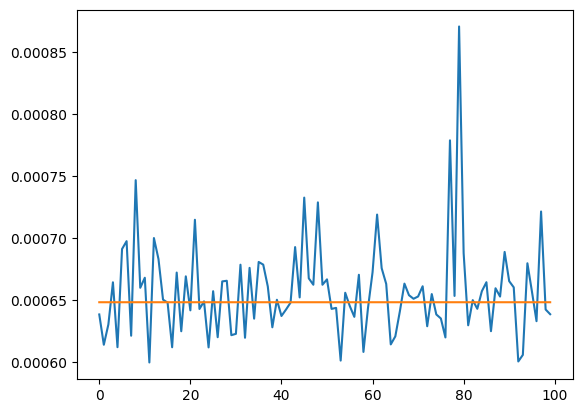

In [69]:
plt.plot(loss_train)
plt.plot(loss_validation)

# Evaluating the model

## Supervised case

### Glitch trained

In [31]:
version = 'v1'

In [34]:
classifier = torch.load("../Model_cached/Wavelet_model_SL"+version+".pt")

In [35]:
classifier.cpu()

WaveletCNNSL(
  (cap_norm): GroupNorm(2, 2, eps=1e-05, affine=True)
  (Conv_In): Conv1d(2, 8, kernel_size=(1,), stride=(1,))
  (Conv_Out): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
  (body_norm): GroupNorm(4, 8, eps=1e-05, affine=True)
  (end_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers): ModuleList(
    (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(16,))
  )
  (L1_norm): BatchNorm1d(169, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L1): Linear(in_features=169, out_features=64, bias=True)
  (L2_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L2): Linear(in_features=64, out_features=16, bias=True)
 

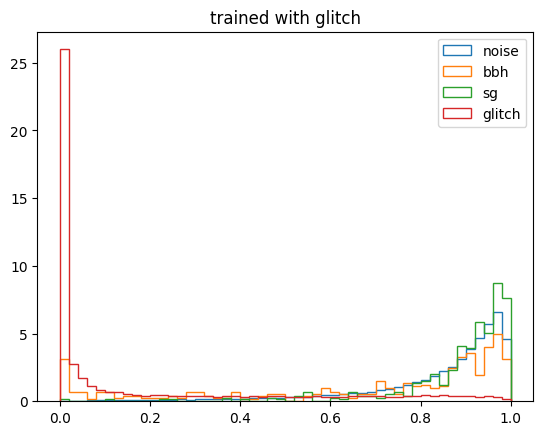

In [37]:
dcd_bkg = nn.Sigmoid()(classifier(torch.FloatTensor(realbkg_reserved))).detach().numpy()
dcd_bbh = nn.Sigmoid()(classifier(torch.FloatTensor(realbbh_reserved))).detach().numpy()
dcd_sg = nn.Sigmoid()(classifier(torch.FloatTensor(realsg_reserved))).detach().numpy()
dcd_glitch = nn.Sigmoid()(classifier(torch.FloatTensor(realglitch_reserved))).detach().numpy()

foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

### Noise trained

In [46]:
version = 'v1'

In [ ]:
classifier = torch.load("../Model_cached/Wavelet_model_SL"+version+".pt")

In [47]:
classifier.cpu()

WaveletCNNSL(
  (cap_norm): GroupNorm(2, 2, eps=1e-05, affine=True)
  (Conv_In): Conv1d(2, 8, kernel_size=(1,), stride=(1,))
  (Conv_Out): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
  (body_norm): GroupNorm(4, 8, eps=1e-05, affine=True)
  (end_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers): ModuleList(
    (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(16,))
  )
  (L1_norm): BatchNorm1d(169, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L1): Linear(in_features=169, out_features=64, bias=True)
  (L2_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L2): Linear(in_features=64, out_features=16, bias=True)
 

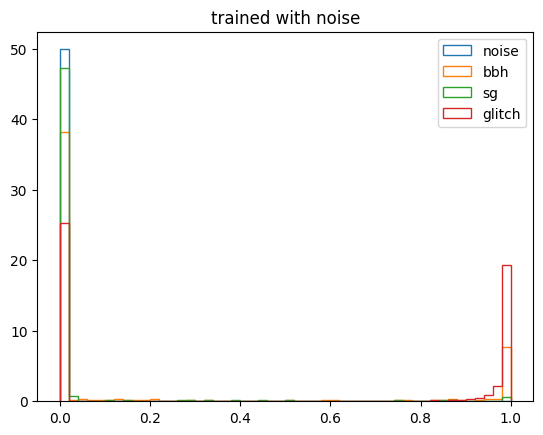

In [49]:
dcd_bkg = nn.Sigmoid()(classifier(torch.FloatTensor(realbkg_reserved))).detach().numpy()
dcd_bbh = nn.Sigmoid()(classifier(torch.FloatTensor(realbbh_reserved))).detach().numpy()
dcd_sg = nn.Sigmoid()(classifier(torch.FloatTensor(realsg_reserved))).detach().numpy()
dcd_glitch = nn.Sigmoid()(classifier(torch.FloatTensor(realglitch_reserved))).detach().numpy()

foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

## Unsupervised case

### Glitch trained

In [194]:
version = 'v10'

In [195]:
classifier = torch.load("../Model_cached/Wavelet_model_glitchtrained_AE"+version+"_32_8.pt")

In [196]:
classifier.cpu()

WaveletCNNAE(
  (cap_norm): GroupNorm(2, 2, eps=1e-05, affine=True)
  (Conv_In_encode): Conv1d(2, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_encode): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
  (Conv_In_decode): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (Conv_Out_decode): Conv1d(4, 2, kernel_size=(1,), stride=(1,))
  (body_norm_encode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (body_norm_decode): GroupNorm(4, 4, eps=1e-05, affine=True)
  (end_norm_encode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (end_norm_decode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers_encode): ModuleList(
    (0): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (1): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(4, 4, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(4, 4, kernel_size=(2,), stride=(1,), d

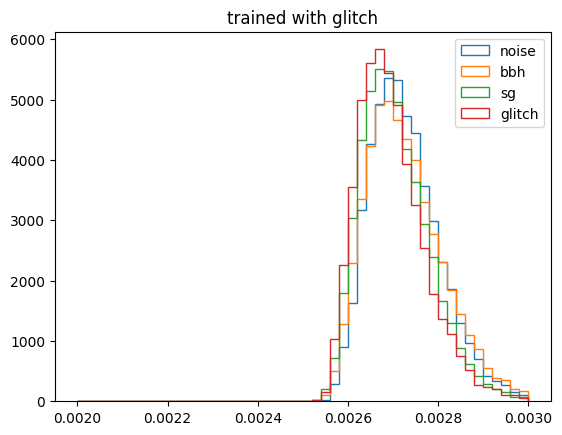

In [176]:
# Model version 12, GWAK glitch trained, No DNN layers

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

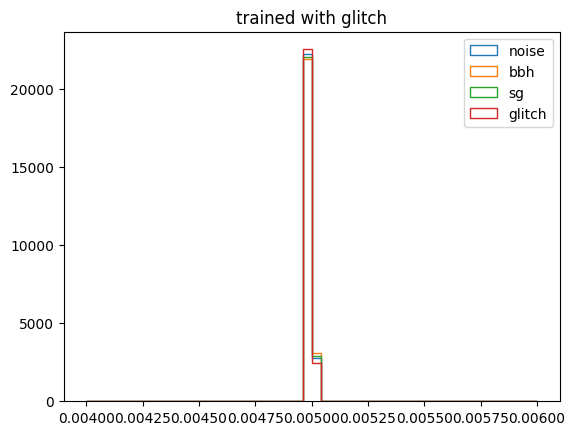

In [193]:
# Model version 11, glitch trained, multi-channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.004, 0.006), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.004, 0.006), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.004, 0.006), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.004, 0.006), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

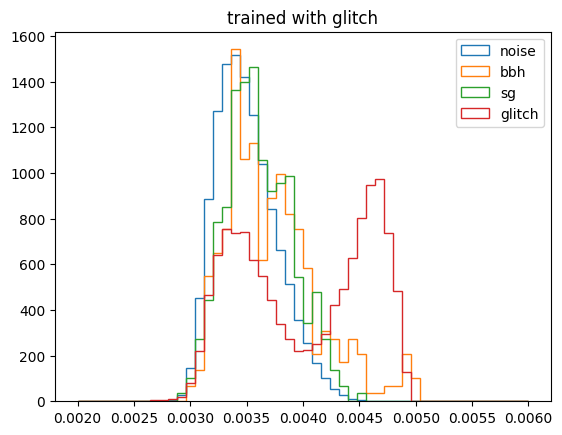

In [198]:
# Model version 10, glitch trained, one channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.002, 0.006), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

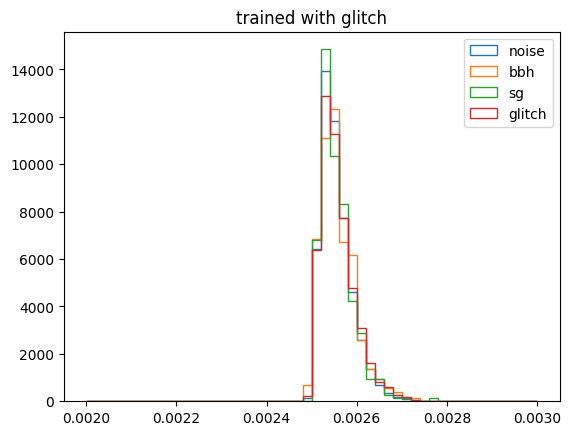

In [158]:
# Model version 9, glitch trained, No DNN layers

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0.002, 0.003), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

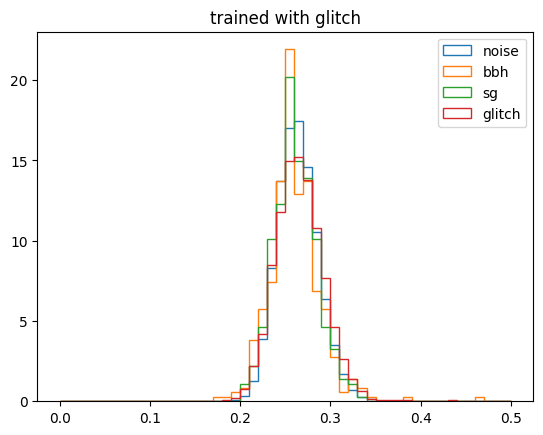

In [120]:
# Model version 8, glitch trained, No DNN layers

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 0.5), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 0.5), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 0.5), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 0.5), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

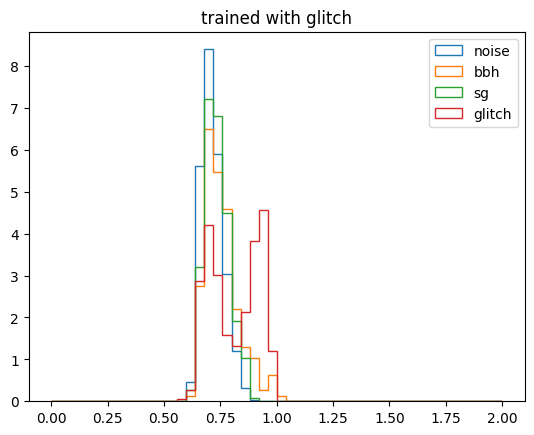

In [111]:
# Model version 7, glitch trained, 32-8, one channel, depth increased

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

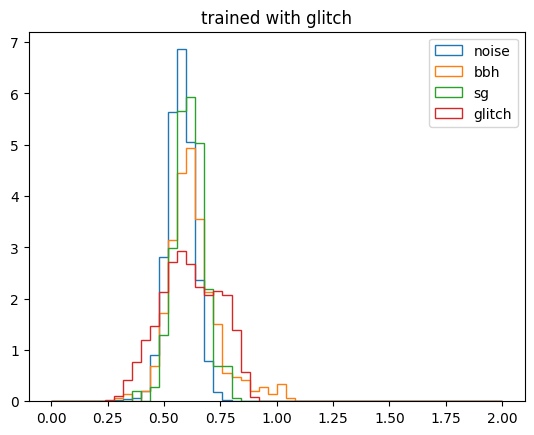

In [101]:
# Model version 5, glitch trained, 32-8, multi-channel

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

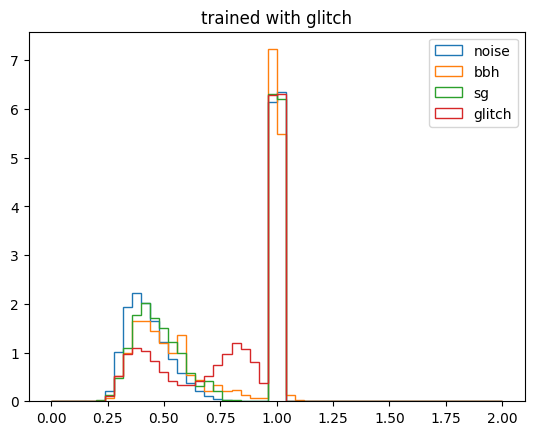

In [85]:
dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

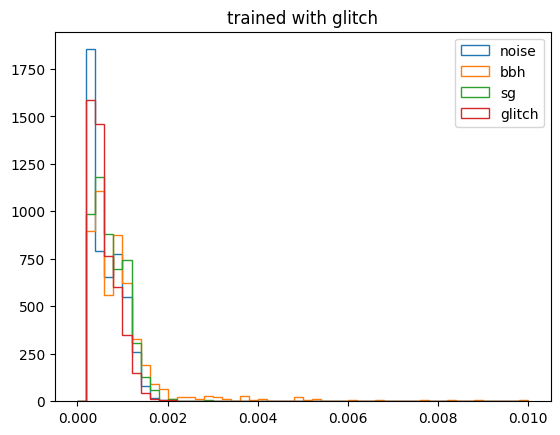

In [59]:
dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

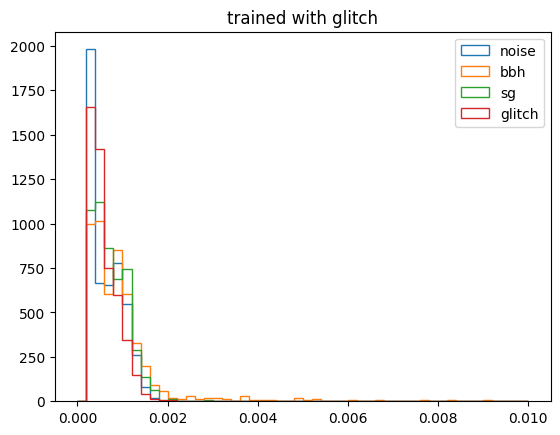

In [ ]:
dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,200)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,200)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,200)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,200)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,200)-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,200)-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,200)-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

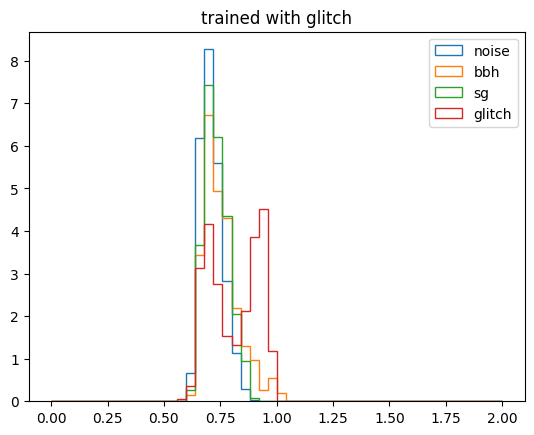

In [97]:
# One channel for DNN
classifier.cpu()

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 2), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

### Noise trained

In [102]:
version = 'v1'

In [103]:
classifier = torch.load("../Model_cached/Wavelet_model_AE"+version+".pt")

In [104]:
classifier.cpu()

WaveletCNNAE(
  (cap_norm): GroupNorm(2, 2, eps=1e-05, affine=True)
  (Conv_In_encode): Conv1d(2, 8, kernel_size=(1,), stride=(1,))
  (Conv_Out_encode): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
  (Conv_In_decode): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
  (Conv_Out_decode): Conv1d(8, 2, kernel_size=(1,), stride=(1,))
  (body_norm_encode): GroupNorm(4, 8, eps=1e-05, affine=True)
  (body_norm_decode): GroupNorm(4, 8, eps=1e-05, affine=True)
  (end_norm_encode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (end_norm_decode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers_encode): ModuleList(
    (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(8, 8, kernel_size=(2,), stride=(1,), d

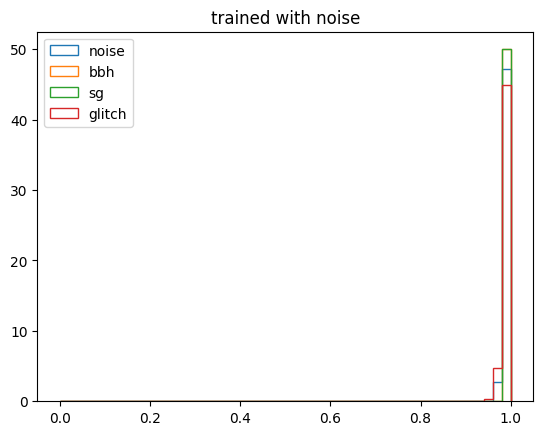

In [106]:
# Noise version 1, one channel for DNN

dcd_bkg = classifier(torch.FloatTensor(realbkg_reserved)).detach().numpy().reshape(-1,400)
dcd_bbh = classifier(torch.FloatTensor(realbbh_reserved)).detach().numpy().reshape(-1,400)
dcd_sg = classifier(torch.FloatTensor(realsg_reserved)).detach().numpy().reshape(-1,400)
dcd_glitch = classifier(torch.FloatTensor(realglitch_reserved)).detach().numpy().reshape(-1,400)

foo = plt.hist(np.var(realbkg_reserved.reshape(-1,400)-dcd_bkg, axis=1), histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(np.var(realbbh_reserved.reshape(-1,400)-dcd_bbh, axis=1), histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(realsg_reserved.reshape(-1,400)-dcd_sg, axis=1), histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(np.var(realglitch_reserved.reshape(-1,400)-dcd_glitch, axis=1), histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [29]:
np.var(realbkg_reserved.reshape(-1,200)-dcd_bkg, axis=1)

array([0.02201537, 0.05003922, 0.02644901, ..., 0.05077039, 0.02142253,
       0.05276636])